# Section 5.5 — Hierarchical models

This notebook contains the code examples from [Section 5.5 Hierarchical models]() from the **No Bullshit Guide to Statistics**.

See also:
- [03_hierarchical_model.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/03_hierarchical_model.ipynb)
- https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section4-Hierarchical_Models.ipynb
- https://mc-stan.org/users/documentation/case-studies/radon_cmdstanpy_plotnine.html#data-prep

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayes/hierarchical"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Definitions

## Model

## Example: radon levels

https://bambinos.github.io/bambi/notebooks/radon_example.html

- Description: Contains measurements of radon levels in homes across various counties.
- Source: Featured in Andrew Gelman and Jennifer Hill's book Data Analysis Using Regression and Multilevel/Hierarchical Models.
- Application: Demonstrates partial pooling and varying intercepts/slopes in hierarchical modeling.


### Data

In [4]:
radon = pd.read_csv("../datasets/radon.csv")
radon

,idnum,state,county,floor,log_radon,log_uranium
0,5081,MN,AITKIN,ground,0.788457,-0.689048
1,5082,MN,AITKIN,basement,0.788457,-0.689048
2,5083,MN,AITKIN,basement,1.064711,-0.689048
3,5084,MN,AITKIN,basement,0.000000,-0.689048
4,5085,MN,ANOKA,basement,1.131402,-0.847313
...,...,...,...,...,...,...
914,5995,MN,WRIGHT,basement,1.856298,-0.090024
915,5996,MN,WRIGHT,basement,1.504077,-0.090024
916,5997,MN,WRIGHT,basement,1.609438,-0.090024
917,5998,MN,YELLOW MEDICINE,basement,1.308333,0.355287


### Bayesian model
TODO: add formulas

### Bambi model

In [5]:
import bambi as bmb

covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
    # "sigma": bmb.Prior("HalfNormal", sigma=10), # from PyStan tutorial
    # "sigma": bmb.Prior("Uniform", lower=0, upper=100), # from PyMC example
}

mod1 = bmb.Model(formula="log_radon ~ 0 + floor + (1|county)",
                 priors=covariate_priors,
                 data=radon,
                 noncentered=False)

mod1

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


       Formula: log_radon ~ 0 + floor + (1|county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

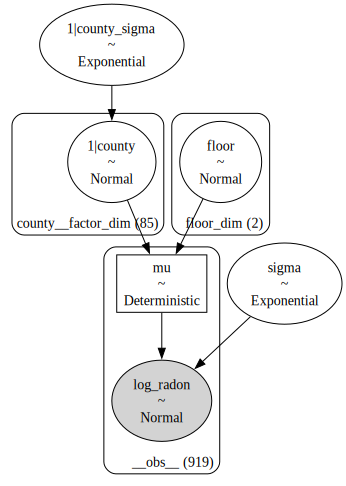

In [6]:
mod1.build()
mod1.graph()

### Model fitting and analysis

In [7]:
idata1 = mod1.fit(draws=2000, 
                  tune=2000,
                  target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, floor, 1|county_sigma, 1|county]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


The group level parameters

In [8]:
import arviz as az
az.summary(idata1).tail(5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|county[YELLOW MEDICINE],-0.077,0.281,-0.616,0.436,0.002,0.003,15838.0,5742.0,1.0
1|county_sigma,0.335,0.047,0.248,0.422,0.001,0.001,3081.0,3880.0,1.0
floor[basement],1.462,0.053,1.360,1.559,0.001,0.001,4481.0,5479.0,1.0
floor[ground],0.769,0.075,0.624,0.904,0.001,0.001,7576.0,6535.0,1.0
sigma,0.757,0.018,0.723,0.791,0.000,0.000,17395.0,6370.0,1.0


The intercept offsets for each county are:

In [9]:
az.summary(idata1).head(5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|county[AITKIN],-0.274,0.260,-0.746,0.226,0.002,0.002,18122.0,6062.0,1.0
1|county[ANOKA],-0.533,0.113,-0.745,-0.323,0.001,0.001,9448.0,6067.0,1.0
1|county[BECKER],0.016,0.266,-0.471,0.522,0.002,0.004,19355.0,5720.0,1.0
1|county[BELTRAMI],0.041,0.219,-0.380,0.438,0.002,0.003,18426.0,4884.0,1.0
1|county[BENTON],-0.015,0.258,-0.488,0.481,0.002,0.003,19092.0,5516.0,1.0


### Conclusions

## Explanations

### Other pooling alternatives

https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html#varying-intercept-model

## Discussion

## Exercises

### Exercise: mod1u

Same model as Example 1 but also include the predictor `log_uranium`.

In [10]:
import bambi as bmb

covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "log_uranium": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

mod1u = bmb.Model(formula="log_radon ~ 0 + floor + (1|county) + log_uranium",
                  priors=covariate_priors,
                  data=radon)

mod1u

       Formula: log_radon ~ 0 + floor + (1|county) + log_uranium
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: 0.0, sigma: 10.0)
            log_uranium ~ Normal(mu: 0.0, sigma: 10.0)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1.0))
        
        Auxiliary parameters
            sigma ~ Exponential(lam: 1.0)

## Links

## EXTRA MATERIAL

### Radon levels

cf. https://github.com/mitzimorris/brms_feb_28_2023/blob/main/brms_notebook.Rmd

#### Complete pooling

In [11]:
mod_cp = bmb.Model("log_radon ~ 1 + floor", data=radon)

In [12]:
mod_cp

       Formula: log_radon ~ 1 + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.3354)
            floor ~ Normal(mu: 0.0, sigma: 5.7237)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

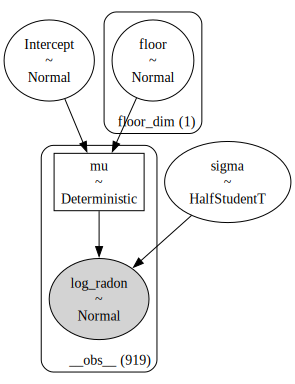

In [13]:
mod_cp.build()
mod_cp.graph()

In [14]:
idata_cp = mod_cp.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [15]:
import arviz as az

az.summary(idata_cp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.327,0.029,1.269,1.379,0.000,0.000,6793.0,2919.0,1.0
floor[ground],-0.614,0.072,-0.756,-0.485,0.001,0.001,6140.0,3473.0,1.0
sigma,0.823,0.019,0.786,0.858,0.000,0.000,6492.0,3132.0,1.0


/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: floor


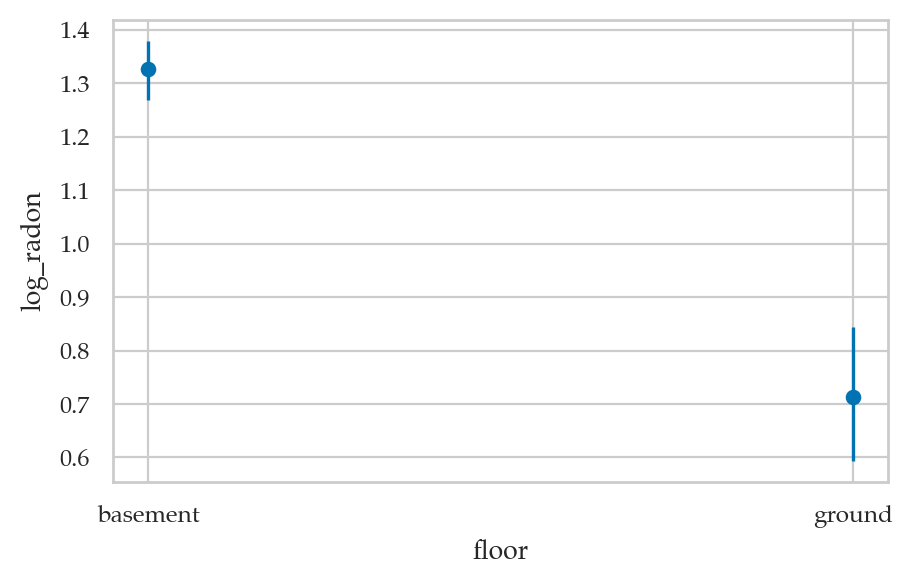

In [16]:
bmb.interpret.plot_predictions(mod_cp, idata_cp, "floor");

#### No pooling

In [17]:
mod_np = bmb.Model("log_radon ~ 0 + county + floor", data=radon)
# mod_np

In [18]:
idata_np = mod_np.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, county, floor]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/Users/ivan/Projects/Minireference/STATSbook/noBSstatsnotebooks/venv/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: floor, county


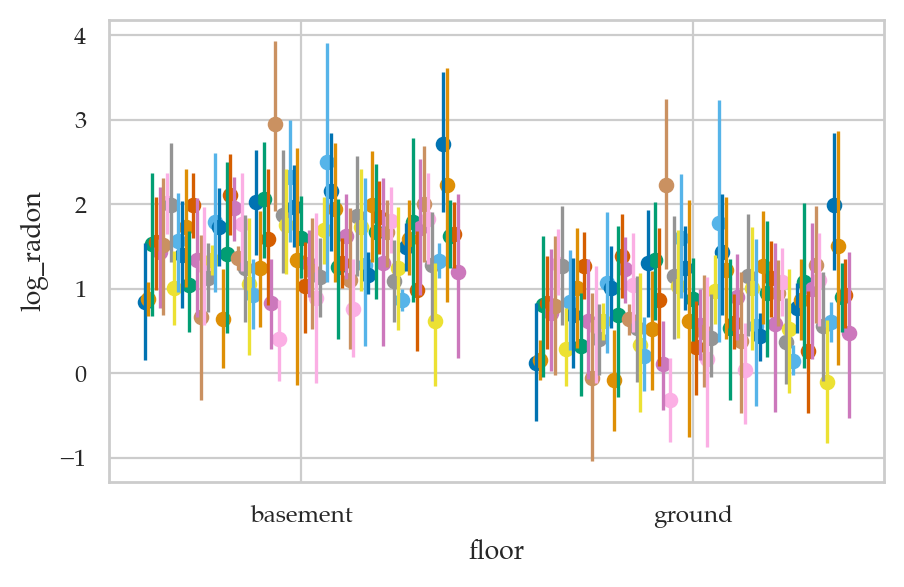

In [19]:
fig, axs = bmb.interpret.plot_predictions(mod_np, idata_np, ["floor", "county"]);
axs[0].get_legend().remove()

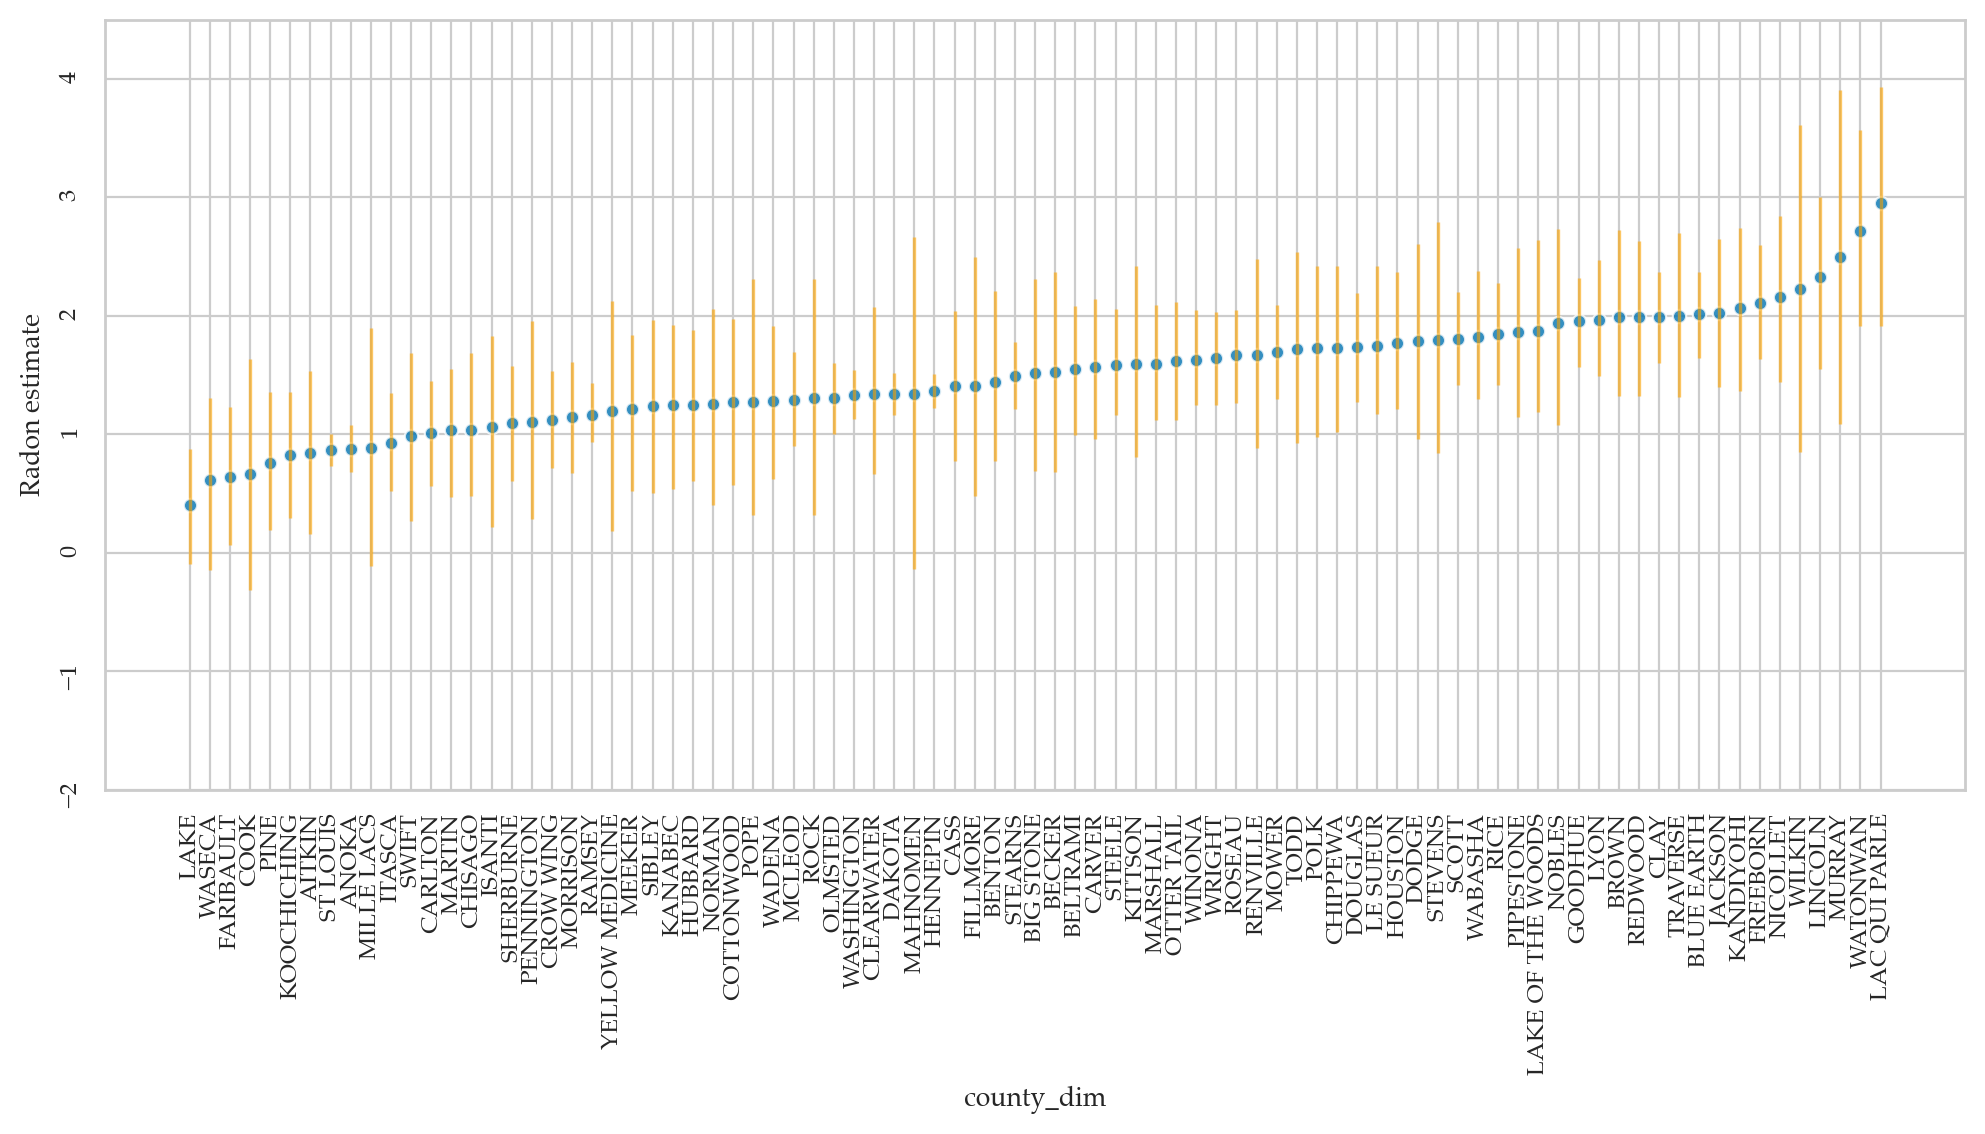

In [20]:
unpooled_means = idata_np.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(idata_np)

unpooled_means_iter = unpooled_means.sortby("county")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.county)

_, ax = plt.subplots(figsize=(12, 5))
unpooled_means_iter.plot.scatter(x="county_dim", y="county", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(len(radon["county"].unique())),
    unpooled_hdi_iter.county.sel(hdi="lower"),
    unpooled_hdi_iter.county.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.tick_params(rotation=90);

#### Partial Pooling Model: varying slope

The partial pooling formula estimates per-county intercepts which drawn
from the same distribution which is estimated jointly with the rest of
the model parameters. The `1` is the intercept co-efficient. The
estimates across counties will all have the same slope.


    log_radon ~ floor + (1 | county_id)


In [21]:
mod_pp1 = bmb.Model("log_radon ~ 0 + (1 | county) + floor", data=radon, center_predictors=False)
mod_pp1

       Formula: log_radon ~ 0 + (1 | county) + floor
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            floor ~ Normal(mu: [0. 0.], sigma: [5.7237 5.7237])
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.3117))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

In [22]:
idata_pp1 = mod_pp1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, floor, 1|county_sigma, 1|county_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


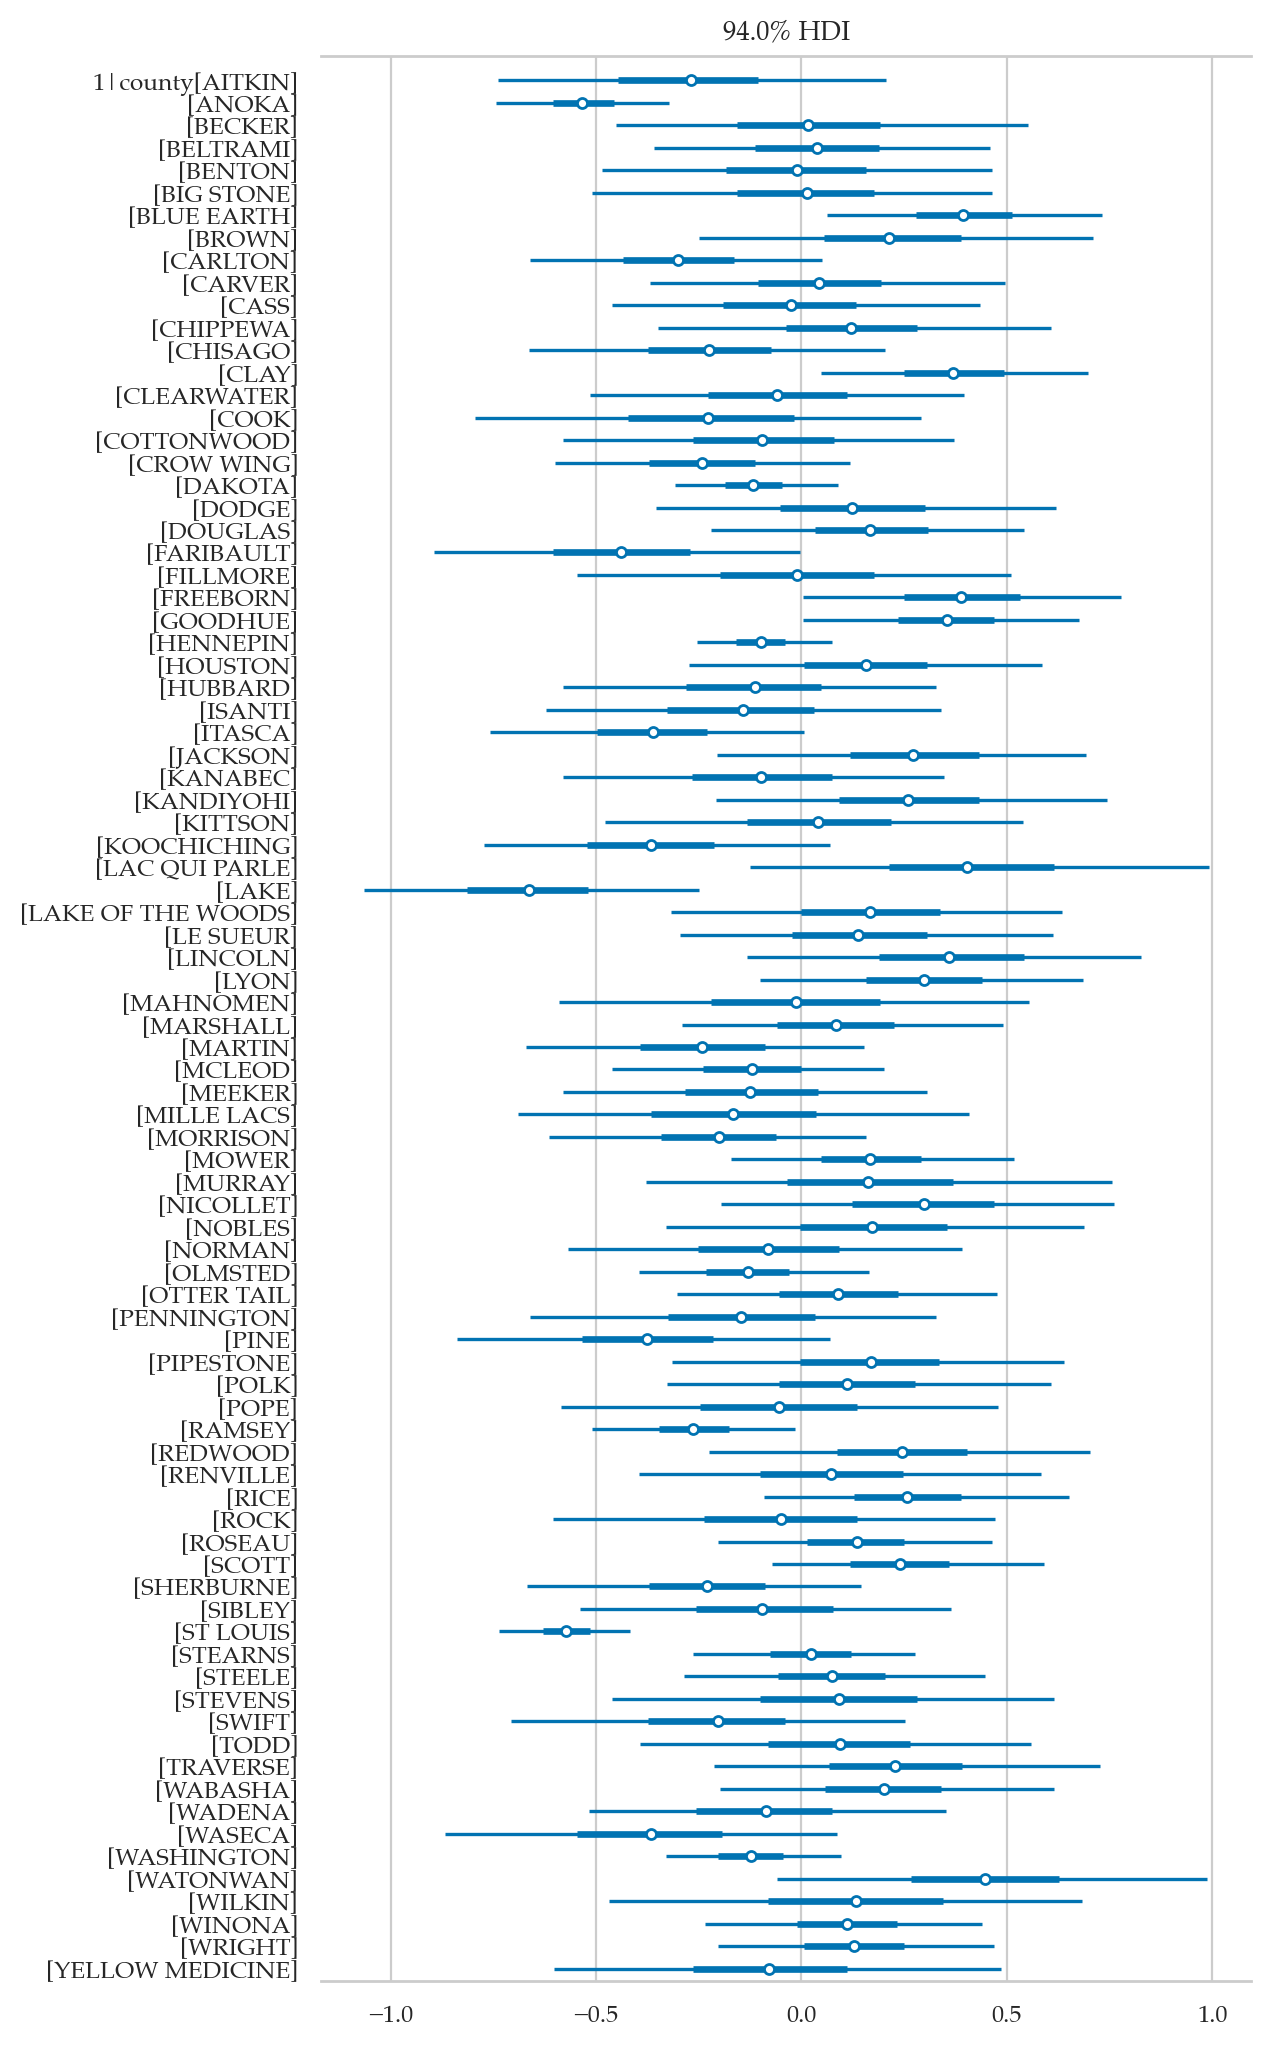

In [23]:
az.plot_forest(idata_pp1, var_names=["1|county"], combined=True);

#### Partial Pooling Model 2: varying slope, varying intercept

The varying-slope, varying intercept model adds `floor` to the
group-level co-efficients. Now estimates across counties will all have
varying slope.

    log_radon ~ floor + (1 + floor | county_id)

In [24]:
mod_pp2 = bmb.Model("log_radon ~ (1 + floor | county)",
                    data=radon,
                    noncentered=False,
                   )
mod_pp2

       Formula: log_radon ~ (1 + floor | county)
        Family: gaussian
          Link: mu = identity
  Observations: 919
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.2246, sigma: 2.1322)
        
        Group-level effects
            1|county ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.1322))
            floor|county ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.7237))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8529)

In [25]:
idata_pp2 = mod_pp2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|county_sigma, 1|county, floor|county_sigma, floor|county]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [26]:
az.autocorr(idata_pp2["posterior"]["sigma"].values.flatten())[0:10]

array([ 1.        , -0.27418583,  0.11544748, -0.02611013,  0.00760068,
       -0.01165492, -0.01462924, -0.00608364, -0.00524214,  0.00850292])

In [27]:
az.summary(idata_pp2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|county[AITKIN],-0.315,0.255,-0.782,0.173,0.003,0.003,6392.0,3330.0,1.0
1|county[ANOKA],-0.472,0.113,-0.685,-0.266,0.002,0.001,4674.0,2905.0,1.0
1|county[BECKER],-0.053,0.285,-0.612,0.449,0.004,0.005,6316.0,2957.0,1.0
1|county[BELTRAMI],0.033,0.250,-0.440,0.496,0.003,0.004,6962.0,3472.0,1.0
1|county[BENTON],-0.053,0.253,-0.542,0.409,0.003,0.004,6515.0,2884.0,1.0
...,...,...,...,...,...,...,...,...,...
"floor|county[ground, WINONA]",-1.352,0.407,-2.123,-0.597,0.006,0.004,5066.0,3211.0,1.0
"floor|county[ground, WRIGHT]",-0.364,0.523,-1.311,0.641,0.006,0.008,7967.0,3040.0,1.0
"floor|county[ground, YELLOW MEDICINE]",-0.000,0.750,-1.470,1.391,0.008,0.014,9077.0,2799.0,1.0
floor|county_sigma[ground],0.743,0.107,0.542,0.939,0.003,0.002,1352.0,1855.0,1.0


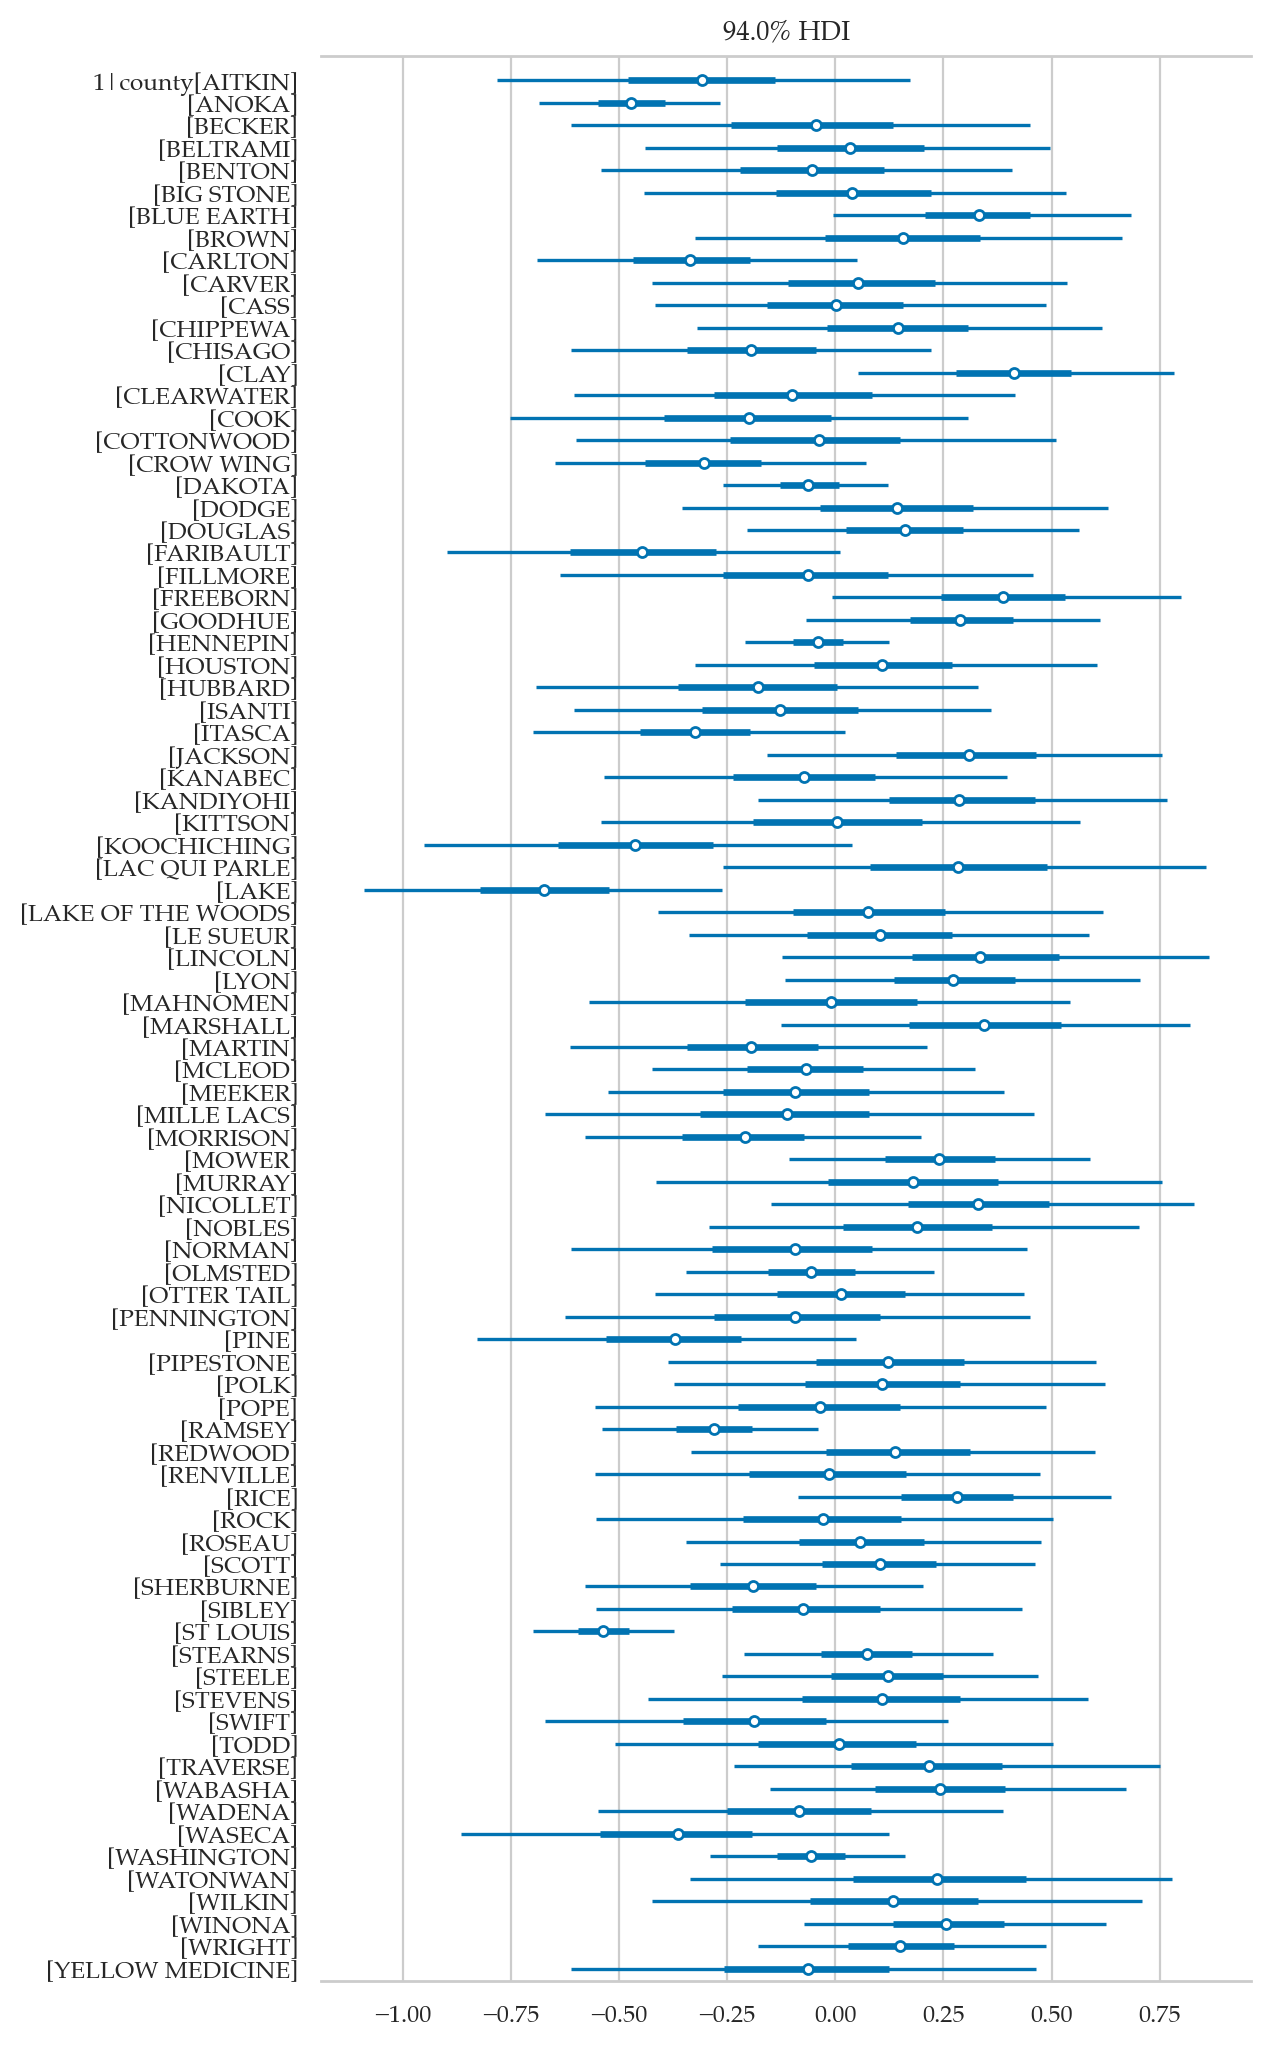

In [28]:
az.plot_forest(idata_pp2, var_names=["1|county"], combined=True);

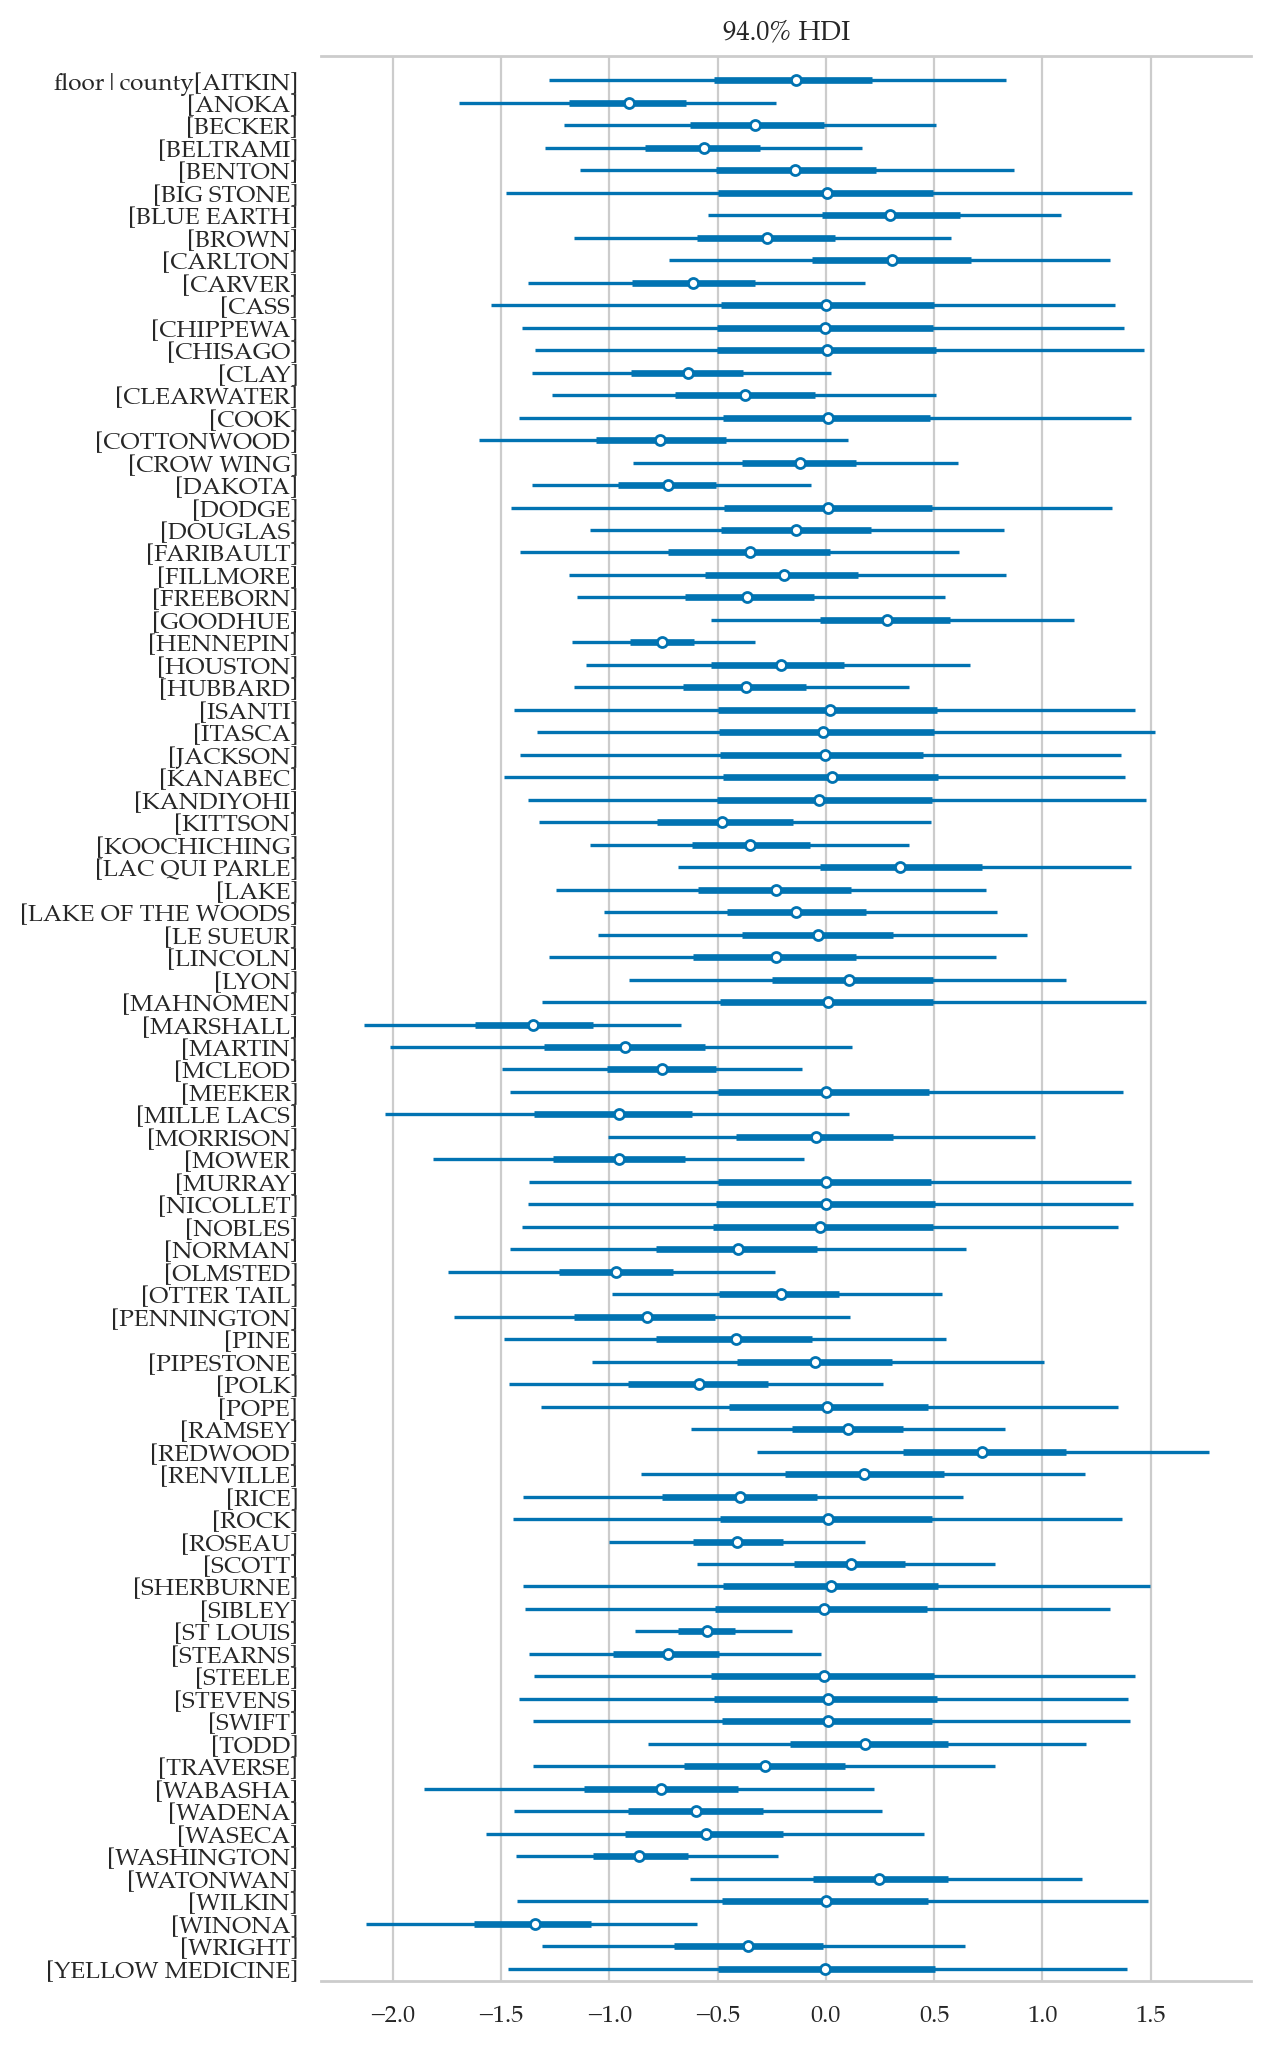

In [29]:
az.plot_forest(idata_pp2, var_names=["floor|county"], combined=True);

#### Compare models

In [30]:

# post_mean

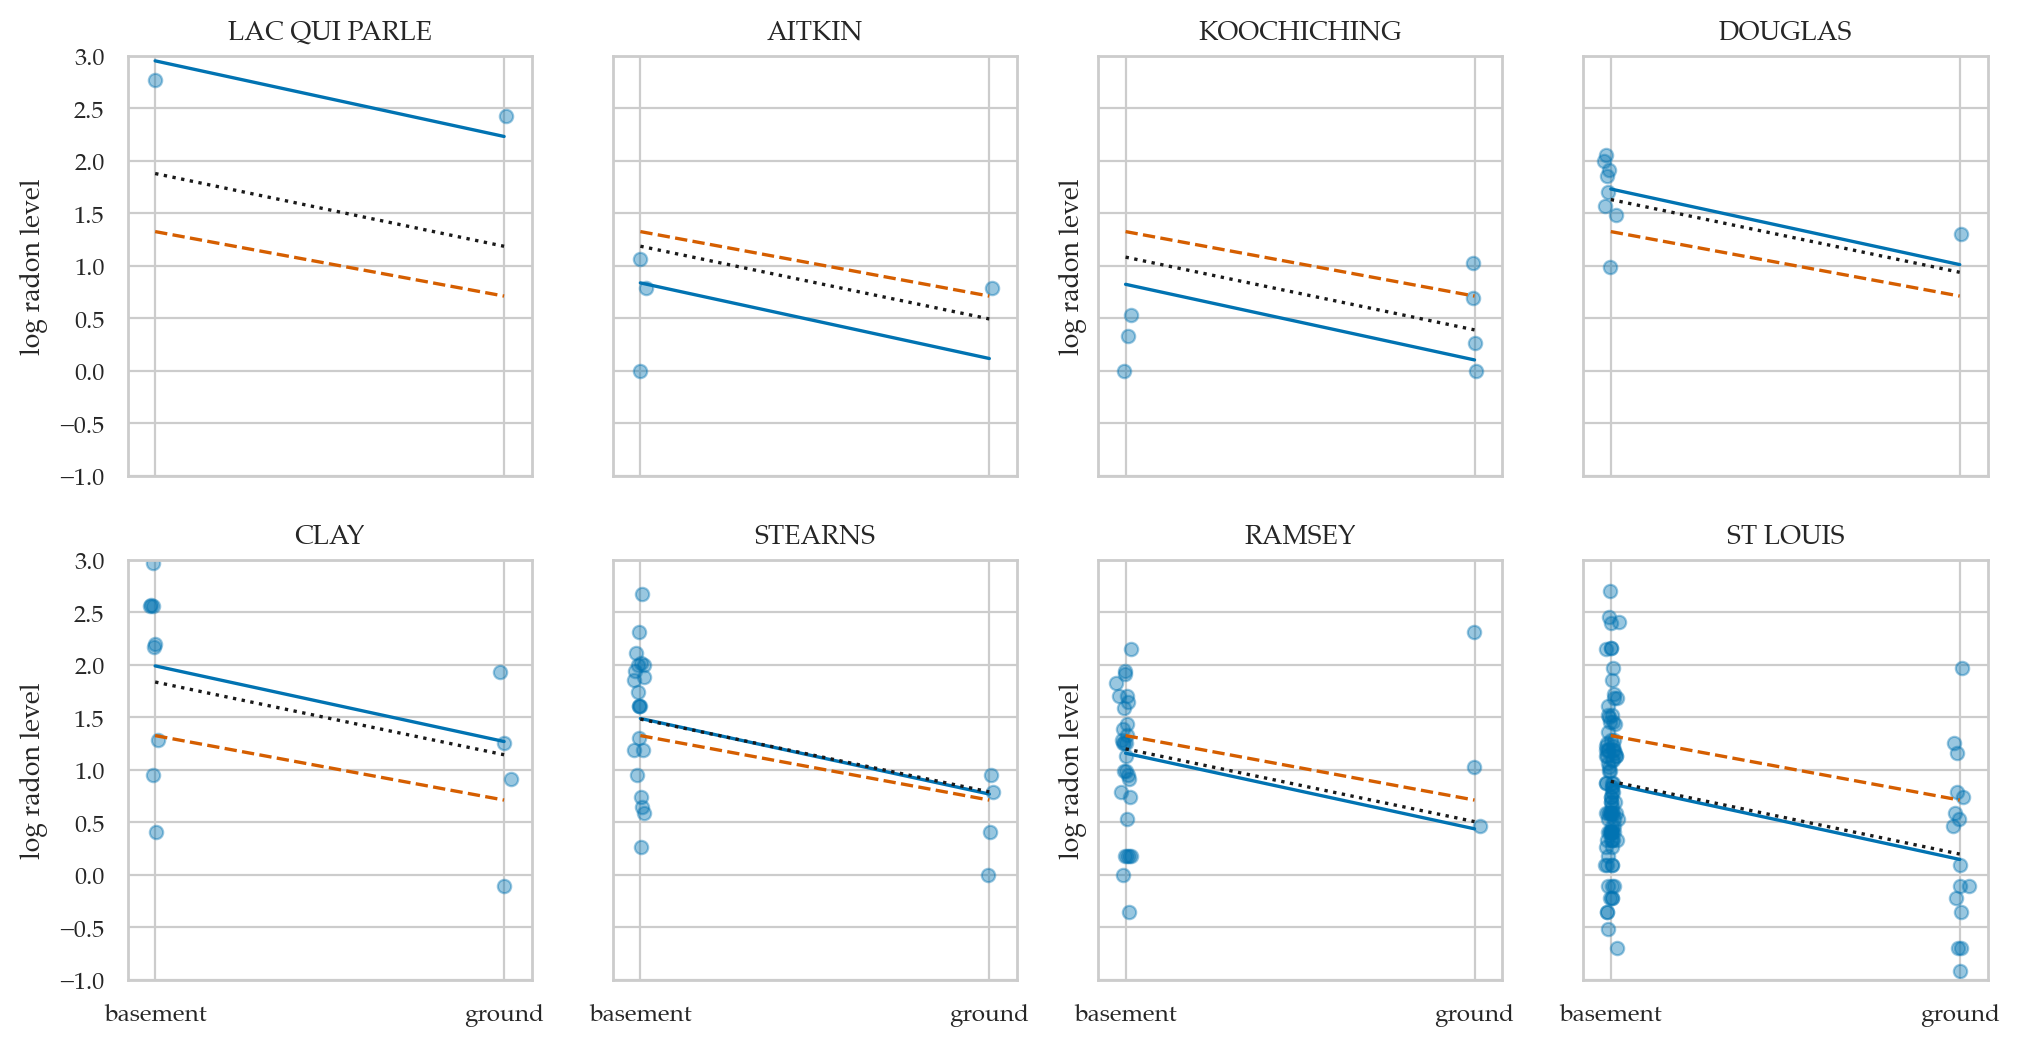

In [31]:
import xarray as xr
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)


# unpooled_means
unpooled_means = idata_np.posterior.mean(dim=("chain", "draw"))

# completely pooled means
post_mean = idata_cp.posterior.mean(dim=("chain", "draw"))


fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_means["floor"]

for i, c in enumerate(sample_counties):
    y = radon.log_radon[radon.county == c]
    x = radon.floor[radon.county == c]
    x = x.map({"basement":0, "ground":1})
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_means["county"].sel(county_dim=c)

    # Plot both models and data
    xvals = xr.DataArray(np.linspace(0, 1))
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, post_mean["floor"].values * xvals + post_mean["Intercept"], "r--")

    # partial pooling
    post = idata1.posterior.sel(county__factor_dim=c).mean(dim=("chain", "draw"))
    slope = post.floor.values[1] - post.floor.values[0]
    theta = post["1|county"].values + post.floor.values[0] + slope * xvals
    axes[i].plot(xvals, theta, "k:")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "ground"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

### Educaitonal data

cf. https://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

1.1 Data example
We will be analyzing the Gcsemv dataset (Rasbash et al. 2000) from the mlmRev package in R. 
The data include the General Certificate of Secondary Education (GCSE) exam scores of 1,905 students from 73 schools in England on a science subject. The Gcsemv dataset consists of the following 5 variables:

- school: school identifier
- student: student identifier
- gender: gender of a student (M: Male, F: Female)
- written: total score on written paper
- course: total score on coursework paper


In [32]:
import pyreadr

# Gcsemv_r = pyreadr.read_r('/Users/ivan/Downloads/mlmRev/data/Gcsemv.rda')
# Gcsemv_r["Gcsemv"].dropna().to_csv("../datasets/gcsemv.csv", index=False)

gcsemv = pd.read_csv("../datasets/gcsemv.csv")
gcsemv.head()

,school,student,gender,written,course
0,20920,27,F,39.0,76.8
1,20920,31,F,36.0,87.9
2,20920,42,M,16.0,44.4
3,20920,101,F,49.0,89.8
4,20920,113,M,25.0,17.5


In [33]:
import bambi as bmb
m1 = bmb.Model(formula="course ~ 1 + (1 | school)", data=gcsemv)
m1

       Formula: course ~ 1 + (1 | school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 41.0781)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 41.0781))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [34]:
idata_m1 = m1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|school_sigma, 1|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [35]:
az.summary(idata_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|school[20920],-6.945,5.132,-16.052,3.346,0.074,0.062,4854.0,2491.0,1.0
1|school[22520],-15.554,2.150,-19.428,-11.419,0.042,0.030,2575.0,3126.0,1.0
1|school[22710],6.284,3.654,-0.891,12.714,0.056,0.042,4185.0,2927.0,1.0
1|school[22738],-0.614,4.398,-8.535,8.035,0.061,0.076,5136.0,2587.0,1.0
1|school[22908],-0.881,6.041,-11.831,10.251,0.075,0.106,6475.0,2859.0,1.0
...,...,...,...,...,...,...,...,...,...
1|school[84707],4.017,7.318,-9.624,17.211,0.094,0.109,6110.0,2541.0,1.0
1|school[84772],8.651,3.590,1.660,15.237,0.054,0.042,4358.0,2573.0,1.0
1|school_sigma,8.764,0.884,7.187,10.492,0.025,0.018,1224.0,1800.0,1.0
Intercept,73.767,1.135,71.637,75.841,0.037,0.026,944.0,1433.0,1.0


In [36]:
m3 = bmb.Model(formula="course ~ gender + (1 + gender|school)", data=gcsemv)
m3

       Formula: course ~ gender + (1 + gender|school)
        Family: gaussian
          Link: mu = identity
  Observations: 1523
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 73.3814, sigma: 53.4663)
            gender ~ Normal(mu: 0.0, sigma: 83.5292)
        
        Group-level effects
            1|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 53.4663))
            gender|school ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 83.5292))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 16.4312)

In [37]:
m3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, gender, 1|school_sigma, 1|school_offset, gender|school_sigma, gender|school_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Sleepstudy dataset

- Description: Contains reaction times of subjects under sleep deprivation conditions.
- Source: Featured in the R package lme4.
- Application: Demonstrates linear mixed-effects modeling with random slopes and intercepts.


https://bambinos.github.io/bambi/notebooks/sleepstudy.html

In [38]:
sleepstudy = bmb.load_data("sleepstudy")
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


### Pigs dataset

https://bambinos.github.io/bambi/notebooks/multi-level_regression.html

In [39]:
import statsmodels.api as sm
dietox = sm.datasets.get_rdataset("dietox", "geepack").data
dietox

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [40]:
pigsmodel = bmb.Model("Weight ~ Time + (Time|Pig)", dietox)
pigsidata = pigsmodel.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Time, 1|Pig_sigma, 1|Pig_offset, Time|Pig_sigma, Time|Pig_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [41]:
az.summary(pigsidata, var_names=["Intercept", "Time", "1|Pig_sigma", "Time|Pig_sigma", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,15.778,0.564,14.712,16.843,0.021,0.015,743.0,1378.0,1.00
Time,6.934,0.079,6.796,7.091,0.003,0.002,729.0,1290.0,1.01
1|Pig_sigma,4.527,0.418,3.758,5.313,0.012,0.009,1201.0,1987.0,1.00
Time|Pig_sigma,0.660,0.064,0.549,0.784,0.002,0.001,1016.0,1836.0,1.00
sigma,2.460,0.065,2.332,2.577,0.001,0.001,5121.0,3088.0,1.00


### Tadpoles

https://www.youtube.com/watch?v=iwVqiiXYeC4

logistic regression model
